## Auger 2010 study

Use the model to fit the dataset first presented in Abreu et al. 2010 containing 69 events with energies E > 55 EeV. Recreate certain figures from Soiaporn et al.

The `arrival_direction` model is a stan implementation of the Soiaporn model with some changes to the parameterisation and priors. The `soiaporn_model` is true to the orginal implementation to allow meaningful comparison. 

In [1]:
import seaborn as sns
import corner
import numpy as np
import h5py

from analysis_interface import Data, Model, Analysis
from analysis_interface.detector.auger2010 import auger_location, theta_m, A, alpha_T, M, kappa_c

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


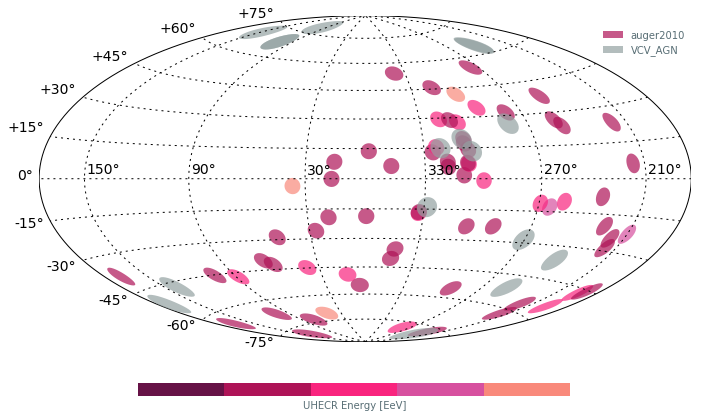

In [2]:
# read in relevant data
source_file = 'data/sourcedata.hdf5'
uhecr_file = 'data/UHECRdata.hdf5'

data = Data()
data.add_uhecr(uhecr_file, 'auger2010')
data.add_source(source_file, 'VCV_AGN')
data.add_detector(auger_location, theta_m, A, alpha_T, kappa_c, 'PAO')
data.show();

## Model for joint inference of $\kappa$

In [3]:
model_name = 'soiaporn_model.stan'
sim_name = 'arrival_direction_sim.stan'

model = Model(model_name, sim_name)
model.compile()

Using cached StanModel
Using cached StanModel


In [4]:
# create simulation to mimic data
Nsim = 100
F_T = Nsim * M / alpha_T
kappa = 100
f = 0.1
model.input(F_T, f, kappa)

print('F_T:', F_T)

F_T: 0.03633874963646063


In [5]:
# define analysis
output_file = 'data/recreateKS2012_testing.hdf5'
with h5py.File(output_file, 'w') as file:
    desc = file.create_group('description')
    desc.attrs['summary'] = b'Testing out the recreation of KS2012.'

analysis = Analysis(data, model, filename = output_file)

# integral tables
table_file = 'data/integration_tables_50_VCV17_auger2010.hdf5'
analysis.use_tables(table_file)

In [ ]:
# simulate
analysis.build_tables(sim_only = True)
analysis.simulate(seed = 19920715)
analysis.save_simulation()

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


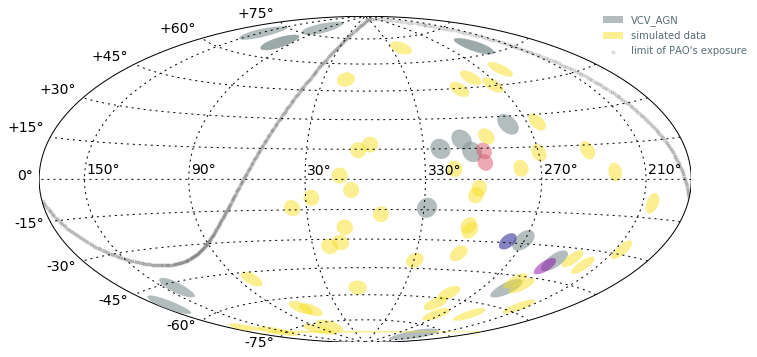

In [6]:
analysis.plot_simulation()

## Compare data and simulation

Quck test to see how simulated dataset performs.

In [7]:
analysis.use_simulation(output_file)
#analysis.use_uhecr_data()

fit = analysis.fit_model()

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


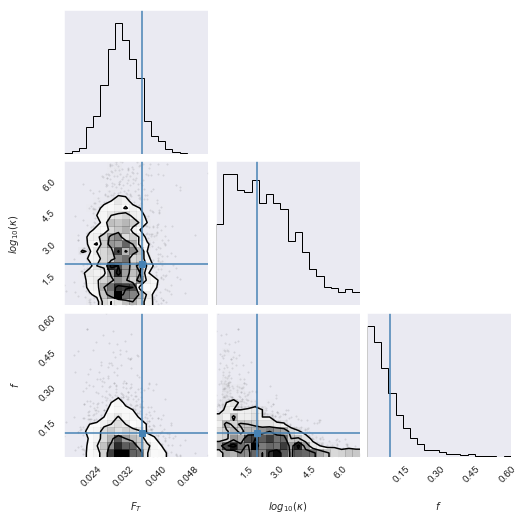

In [10]:
chain = fit.extract(permuted=True)
corner.corner(
    np.column_stack([chain[key] for key in ['F_T', 'log_kappa', 'f']]),
    labels=[r'$F_T$', r'$log_{10}(\kappa)$', r'$f$'],
    truths=[F_T, np.log10(kappa), f]);

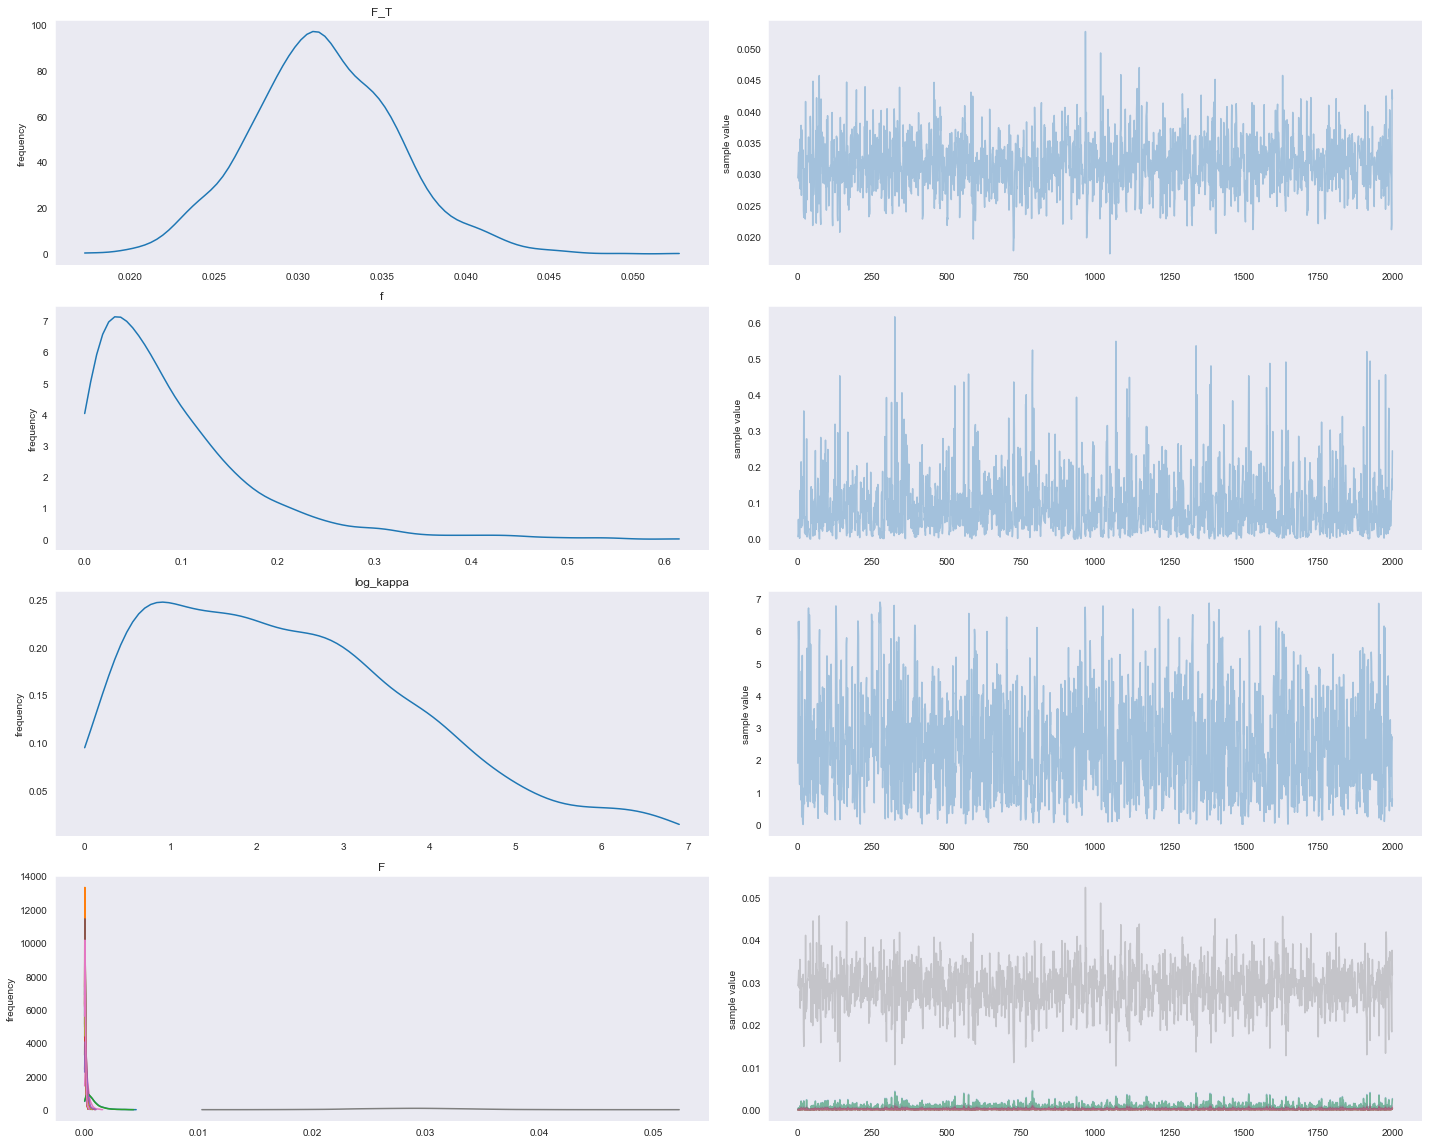

In [12]:
fig = fit.plot(['F_T', 'f', 'log_kappa', 'F']);
fig.set_size_inches(20, 16)
fig.tight_layout()

In [7]:
analysis.use_uhecr_data()
fit = analysis.fit_model()

preparing fit inputs...
done
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


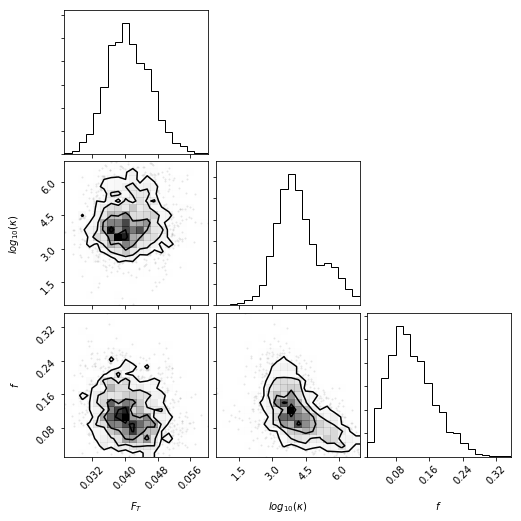

In [8]:
chain = fit.extract(permuted=True)
corner.corner(
    np.column_stack([chain[key] for key in ['F_T', 'log_kappa', 'f']]),
    labels=[r'$F_T$', r'$log_{10}(\kappa)$', r'$f$']);

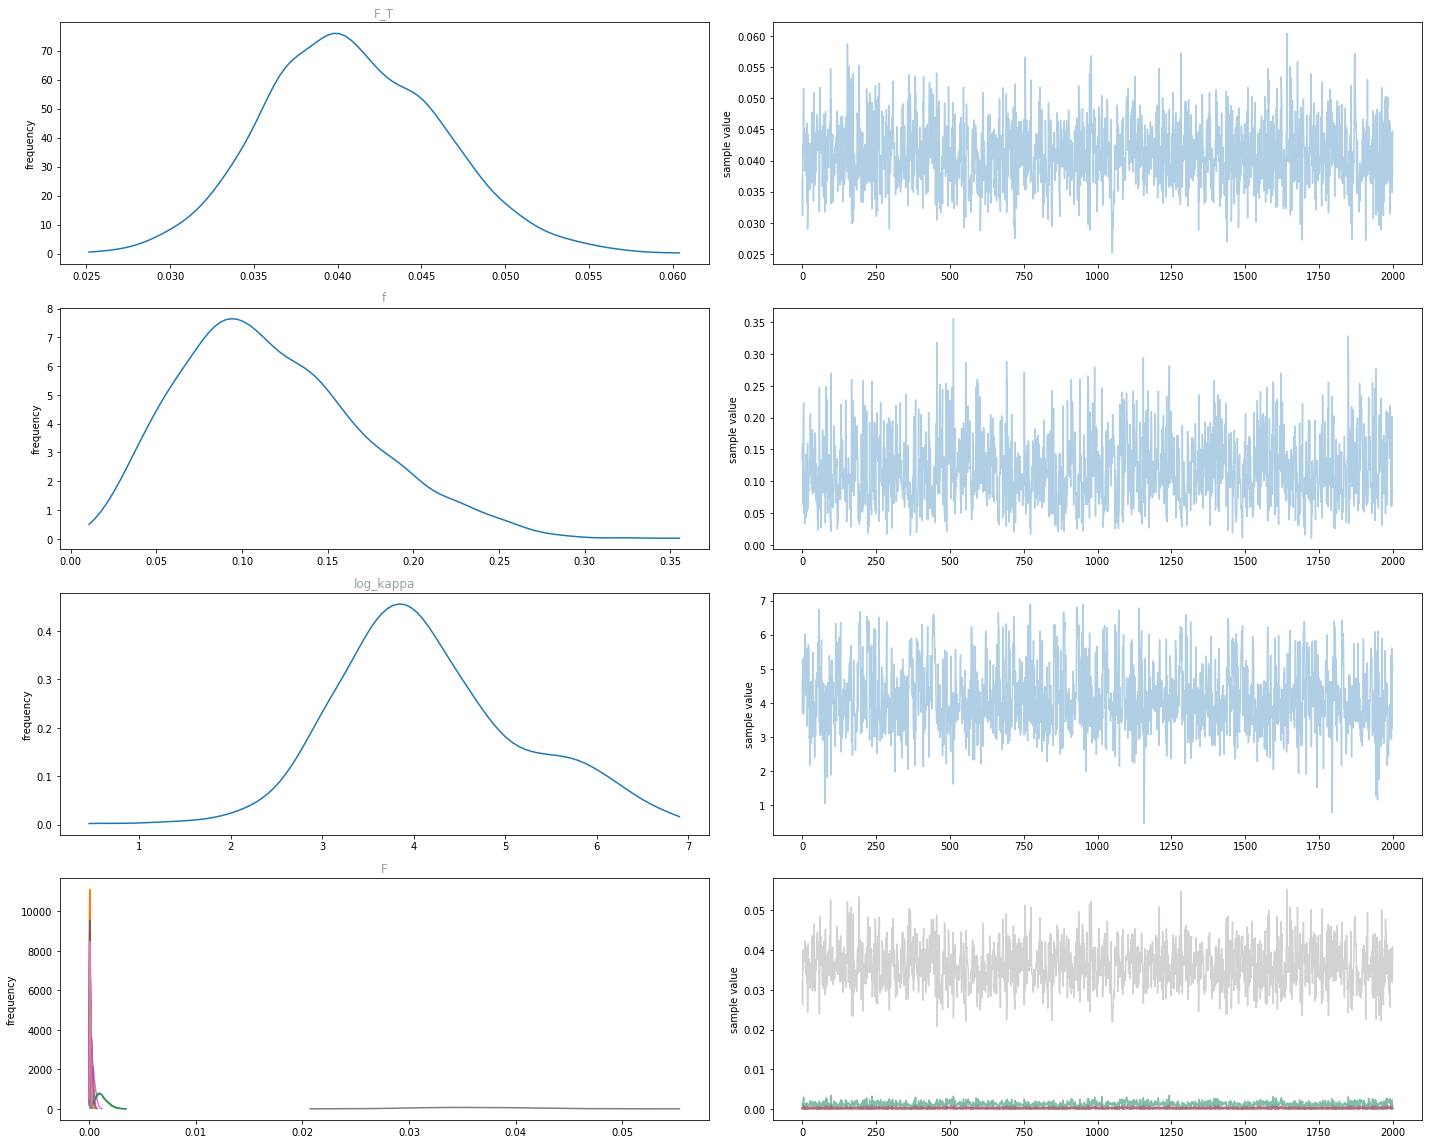

In [9]:
fig = fit.plot(['F_T', 'f', 'log_kappa', 'F']);
fig.set_size_inches(20, 16)
fig.tight_layout()

## Recreate Figure 5

Plot the marginal join posterior distributions for f and $\kappa$ for different periods. 

In [6]:
import pystan

In [7]:
# Fig 5, top right: all periods, 17 AGN
analysis.use_uhecr_data()

fit = analysis.fit_model(chains = 6, iterations = 20000)
chain = fit.extract(permuted=True)
samples = {'f' : chain['f'], 'log10_kappa' : np.log10(chain['kappa'])}

data_file = 'data/soiapornfig5a.data.R'
pystan.stan_rdump(samples, data_file)

AttributeError: 'Analysis' object has no attribute 'E_grid'

In [ ]:
print(fit)

In [18]:
# Fig 5, top left:  periods 2 and 3, 17 AGN
analysis.data.uhecr.select_period([2, 3])
analysis.use_uhecr_data()

fit = analysis.fit_model(chains = 6, iterations = 20000)
chain = fit.extract(permuted=True)
samples = {'f' : chain['f'], 'log10_kappa' : np.log10(chain['kappa'])}
data_file = 'data/soiapornfig5b.data.R'
pystan.stan_rdump(samples, data_file)

preparing fit inputs...
done


/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0 of 60000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 60000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior


In [19]:
print(fit)

Inference for Stan model: anon_model_29b1bff02453bb8b35de9fd8a4916274.
6 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=60000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
F_T         0.03  2.6e-5 4.5e-3   0.02   0.03   0.03   0.04   0.04  30637    1.0
f           0.09  4.1e-4   0.07   0.01   0.05   0.08   0.13   0.26  25155    1.0
log_kappa   3.96    0.01   1.59   0.89   2.86   3.77   5.25   6.76  25039    1.0
F[0]      5.7e-5  2.4e-7 3.8e-5 7.2e-6 2.9e-5 4.9e-5 7.7e-5 1.5e-4  26613    nan
F[1]      5.3e-5  2.2e-7 3.6e-5 6.7e-6 2.7e-5 4.6e-5 7.2e-5 1.4e-4  26613    nan
F[2]      7.9e-5  3.3e-7 5.3e-5 9.9e-6 4.0e-5 6.8e-5 1.1e-4 2.1e-4  26613    nan
F[3]      6.4e-5  2.6e-7 4.3e-5 8.0e-6 3.3e-5 5.5e-5 8.6e-5 1.7e-4  26613    nan
F[4]      9.1e-5  3.7e-7 6.1e-5 1.1e-5 4.6e-5 7.8e-5 1.2e-4 2.4e-4  26613    nan
F[5]      7.7e-5  3.2e-7 5.2e-5 9.6e-6 3.9e-5 6.6e-5 1.0e-4 2.0e-4  26613    n

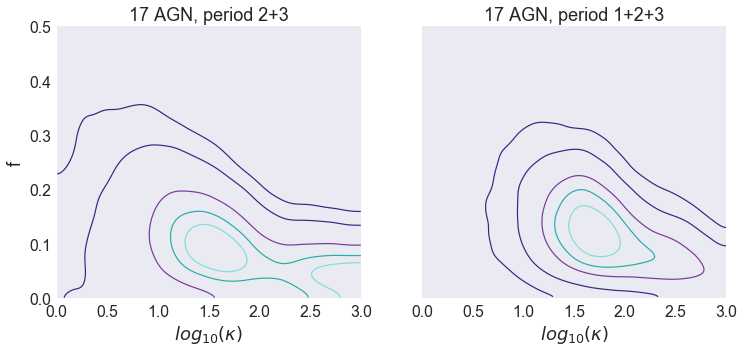

In [24]:
# make easy to compare plots
import vapeplot
from utils.soiaporn_plots import make_fig_5_plot
sns.set_style('dark')
cmap = vapeplot.cmap('jazzcup')

chain_a = pystan.read_rdump('data/soiapornfig5a.data.R')
chain_b = pystan.read_rdump('data/soiapornfig5b.data.R')
levels = [0.25, 0.5, 0.75, 0.95, 0.99]

fig = make_fig_5_plot(chain_a, chain_b, levels, 15, cmap = cmap)
fig.savefig('figures/soiaporn_fig5.png', facecolor='w', bbox_inches = 'tight')

## Recreate Figure 4

Plot the marginal posterior of f, conditioned on $\kappa$ = [10, 31.6, 100, 316, 1000]. To do this, need to use different stan model with kappa fixed.

In [ ]:
from fancy.interfaces import stan_utility
fixedkappa_model = stan_utility.compile_model('../stan/soiaporn_model_fixedkappa.stan')

In [ ]:
# refresh data to have all AGN
data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')

# get interpolation table
my_table = pystan.read_rdump(table_file)
eps = my_table['table']
kappa_grid = my_table['kappa']
Ngrid = len(kappa_grid)
kappa = [10, 31.6, 100, 316, 1000]

In [ ]:

f = []
for k in kappa:
    model_inputs = {'N_A' : data.source.N, 'varpi' : data.source.unit_vector, 
                    'D' : data.source.distance, 'N' : data.uhecr.N, 
                    'detected' : data.uhecr.unit_vector, 
                    'zenith_angle' : data.uhecr.incidence_angle, 'A' : data.uhecr.A,
                    'kappa_c' : kappa_c, 'alpha_T' : alpha_T, 'Ngrid' : Ngrid, 
                    'eps' : eps, 'kappa_grid' : kappa_grid, 'kappa' : k}
    
    fit = fixedkappa_model.sampling(data = model_inputs, iter = 5000, chains = 4, 
                                seed = 19920715)
    chain = fit.extract(permuted = True)
    f_samples = chain['f']
    f.append(f_samples)

In [ ]:
#pystan.stan_rdump({'f' : f}, 'data/soiaporn_fig4.data.R')
f = pystan.read_rdump('data/soiaporn_fig4.data.R')['f']

In [ ]:
from matplotlib import pyplot as plt
vapeplot.set_palette('jazzcup')

i = 0
plt.figure(figsize = (7, 5))
for f_samples in f:
    sns.distplot(f_samples, label = '$\kappa$ = ' + str(kappa[i]))
    i += 1
plt.xlabel('f')
plt.ylabel('posterior density of f')
plt.legend()
plt.savefig('figures/soiaporn_fig4.png', facecolor='w')